In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
#import graphviz 
#import pydotplus
from sklearn.datasets import load_iris, load_wine
#load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(wine_X_train[:, [6,11]], wine_y_train)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = wine_X_train[:, 6], wine_X_train[:, 11]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=wine_y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [3]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

In [4]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [5]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

## Разделим выборку на обучающую и тестовую


In [6]:
# Используем датасет wine с 6 и 11  признаками
wine = load_wine()
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=10)
#wine_X_train_new = wine_X_train.data[:, [6,11]]
#wine_X_test_new = wine_X_test.data[:, [6,11]]

# Модели бэггинга и случайного леса

## Бэггинг



### Реализация в scikit-learn

Метод бэггинга реализуется в scikit-learn с помощью классов [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) и [BaggingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

#### Изучение BaggingClassifier

In [7]:
# Обучим классификатор на 5 деревьях
bc1 = BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)
bc1.fit(wine_X_train, wine_y_train)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:769: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:775: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)

In [8]:
bin_array = np.zeros((5, wine_X_train.shape[0]))
for i in range(5):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       

In [9]:
# Оценим Out-of-bag error, теоретическое значение 37%
for i in range(5):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 38.71%
Для модели № 2 размер OOB составляет 37.9%
Для модели № 3 размер OOB составляет 34.68%
Для модели № 4 размер OOB составляет 33.87%
Для модели № 5 размер OOB составляет 37.9%


In [10]:
# Out-of-bag error, возвращаемый классификатором
# Для классификации используется метрика accuracy
bc1.oob_score_, 1-bc1.oob_score_

(0.8629032258064516, 0.13709677419354838)

In [11]:
# Параметр oob_decision_function_ возвращает вероятности 
# принадлежности объекта к классам на основе oob
# В данном примере три класса, 
# значения nan могут возвращаться в случае маленькой выборки
bc1.oob_decision_function_[55:70]

array([[0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [       nan,        nan,        nan],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.66666667, 0.33333333],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [       nan,        nan,        nan],
       [0.        , 1.        , 0.        ]])

In [12]:
pred_wine_y_test = bc1.predict(wine_X_test)
pred_wine_y_test

array([1, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 0, 2,
       0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 2, 1,
       0, 1, 2, 1, 1, 1, 2, 1, 2, 0])

In [13]:
accuracy_score(wine_y_test, pred_wine_y_test)

0.8888888888888888

In [14]:
print_accuracy_score_for_classes(wine_y_test, pred_wine_y_test)

Метка 	 Accuracy
0 	 0.9333333333333333
1 	 0.8148148148148148
2 	 1.0


Можно отметить, что деревья получаются различными. Таким образом, каждое дерево работает как "слабая модель".

#### Визуализация результатов классификации

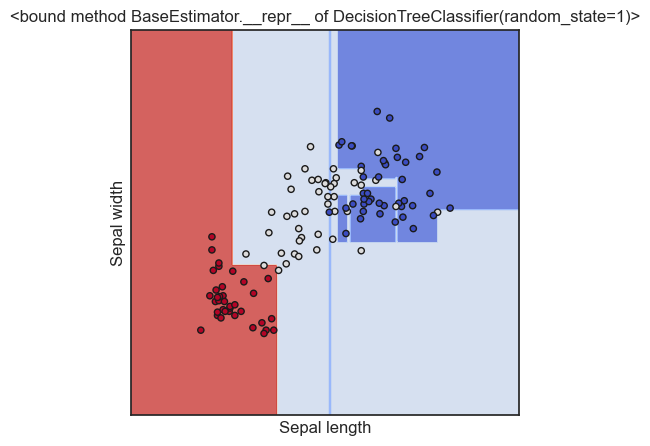

In [15]:
plot_cl(DecisionTreeClassifier(random_state=1))

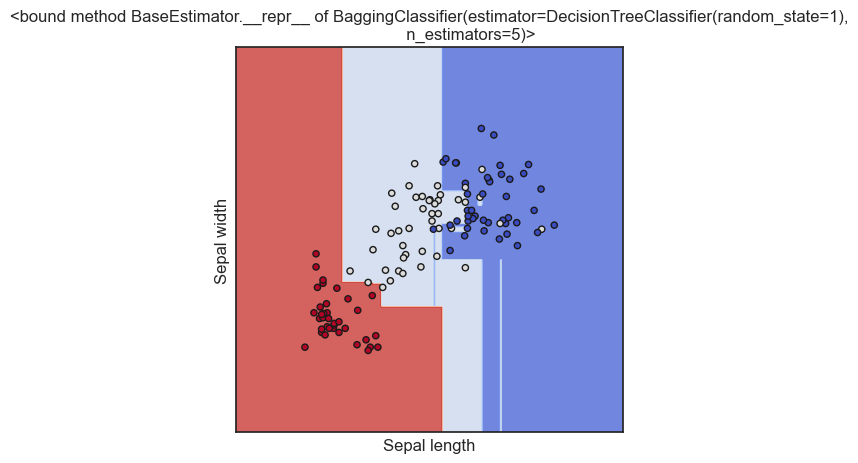

In [16]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=5))

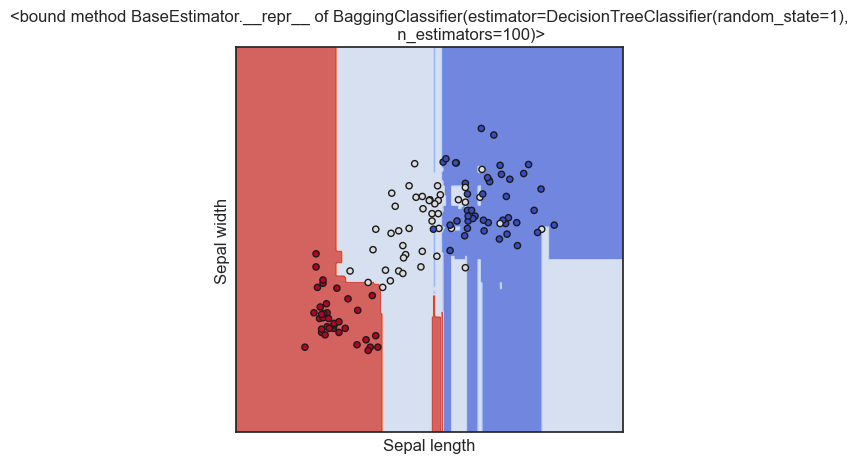

In [17]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100))

## [Случайный лес](https://ru.wikipedia.org/wiki/Random_forest) 


Случайный лес реализуется в scikit-learn с помощью классов [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) и [RandomForestRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) Задание параметра n_jobs=-1 распараллеливает алгоритм на максимально возможное количество процессоров. 

In [18]:
# Обучим классификатор на 5 деревьях
tree1 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
tree1.fit(wine_X_train, wine_y_train)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)

In [19]:
# Out-of-bag error, возвращаемый классификатором
tree1.oob_score_, 1-tree1.oob_score_

(0.8629032258064516, 0.13709677419354838)

In [20]:
tree1.oob_decision_function_[55:70]

array([[0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [0.        , 0.75      , 0.25      ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ]])

In [21]:
pred_wine_y_test_1 = tree1.predict(wine_X_test)
pred_wine_y_test_1

array([1, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 2,
       0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1,
       0, 1, 2, 1, 1, 0, 2, 1, 2, 0])

In [22]:
accuracy_score(wine_y_test, pred_wine_y_test_1)

0.9444444444444444

In [23]:
print_accuracy_score_for_classes(wine_y_test, pred_wine_y_test_1)

Метка 	 Accuracy
0 	 1.0
1 	 0.8888888888888888
2 	 1.0


Можно отметить, что в случае случайного леса деревья получаются более разнообразными, чем в случае бэггинга.

### Визуализация результатов классификации

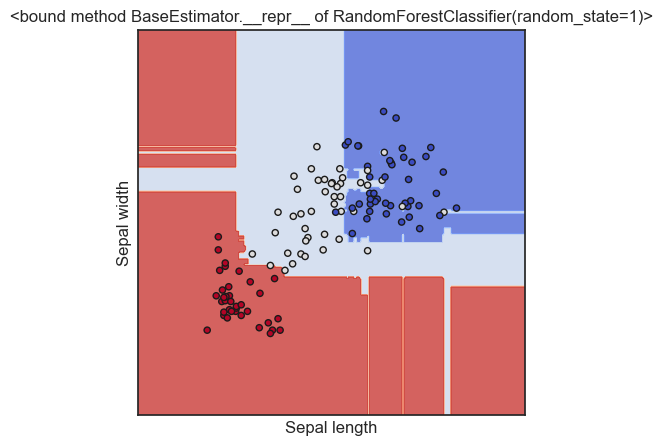

In [24]:
plot_cl(RandomForestClassifier(random_state=1))

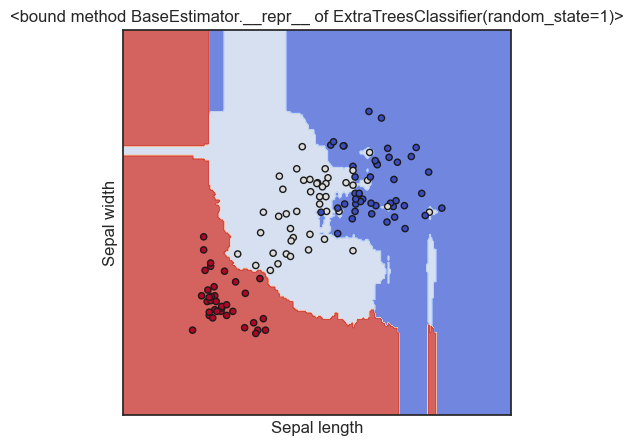

In [25]:
plot_cl(ExtraTreesClassifier(random_state=1))

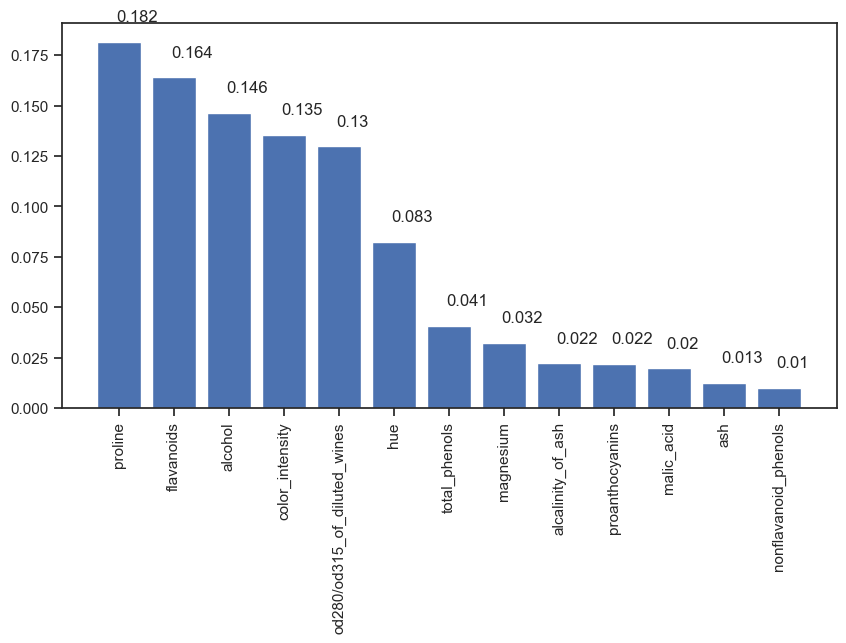

In [26]:
# Важность признаков
wine_x_ds = pd.DataFrame(data=wine['data'], columns=wine['feature_names'])
wine_rf_cl = RandomForestClassifier(random_state=1)
wine_rf_cl.fit(wine_x_ds, wine.target)
_,_ = draw_feature_importances(wine_rf_cl, wine_x_ds)

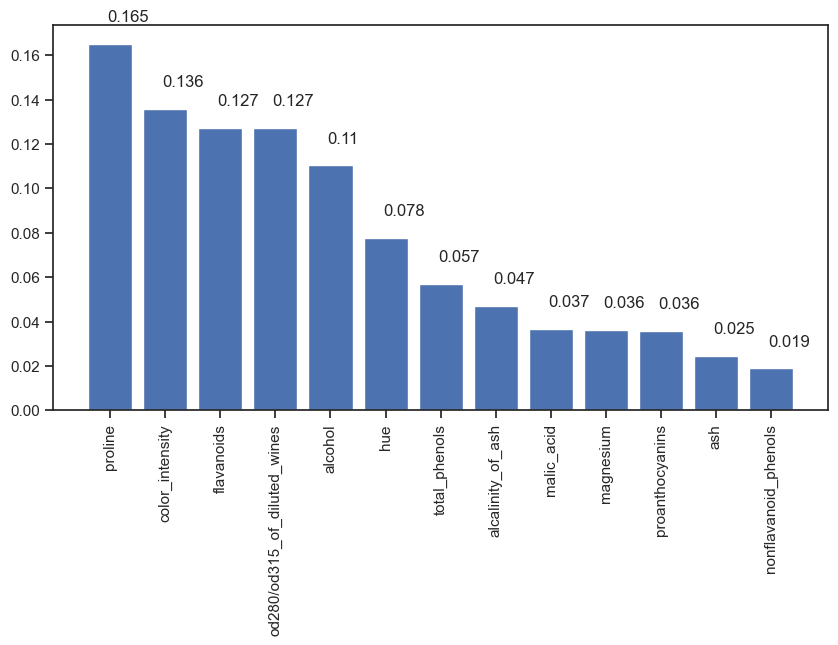

In [27]:
wine_xtree_cl = ExtraTreesClassifier(random_state=1)
wine_xtree_cl.fit(wine_x_ds, wine.target)
_, _ = draw_feature_importances(wine_xtree_cl, wine_x_ds)

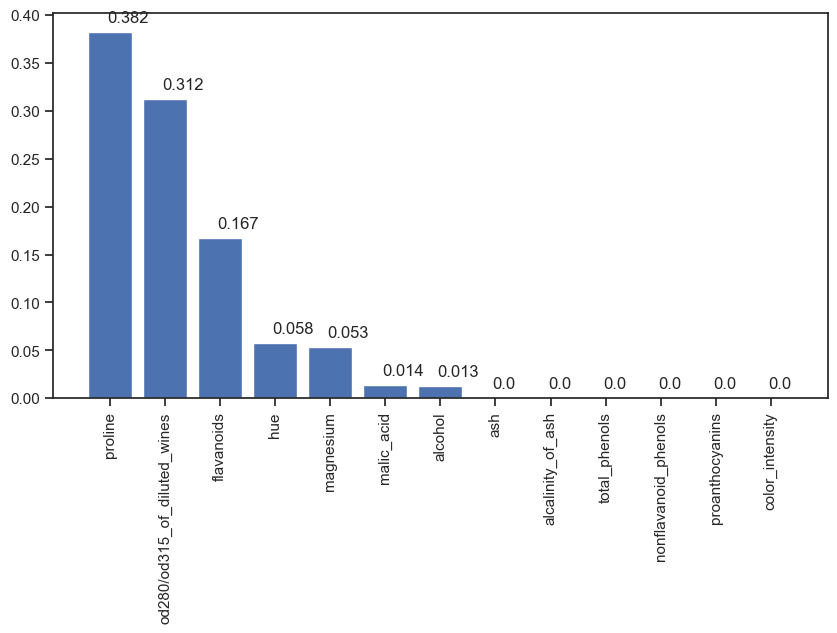

In [28]:
wine_tree_cl = DecisionTreeClassifier(random_state=1)
wine_tree_cl.fit(wine_x_ds, wine.target)
_,_ = draw_feature_importances(wine_tree_cl, wine_x_ds)

## AdaBoost

In [29]:
ab1 = AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=10)
ab1.fit(wine_X_train, wine_y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=10)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


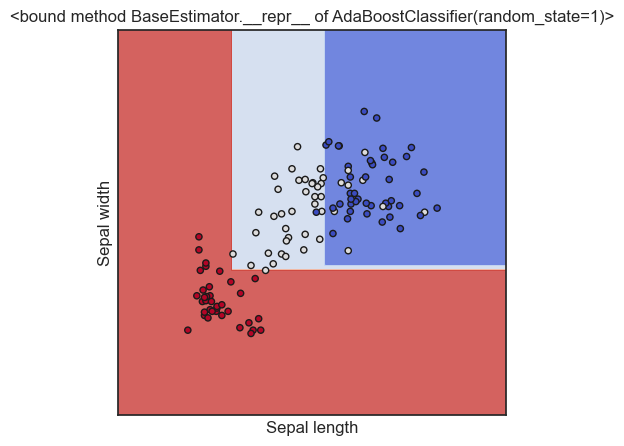

In [30]:
# Результаты классификации
plot_cl(AdaBoostClassifier(random_state=1))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


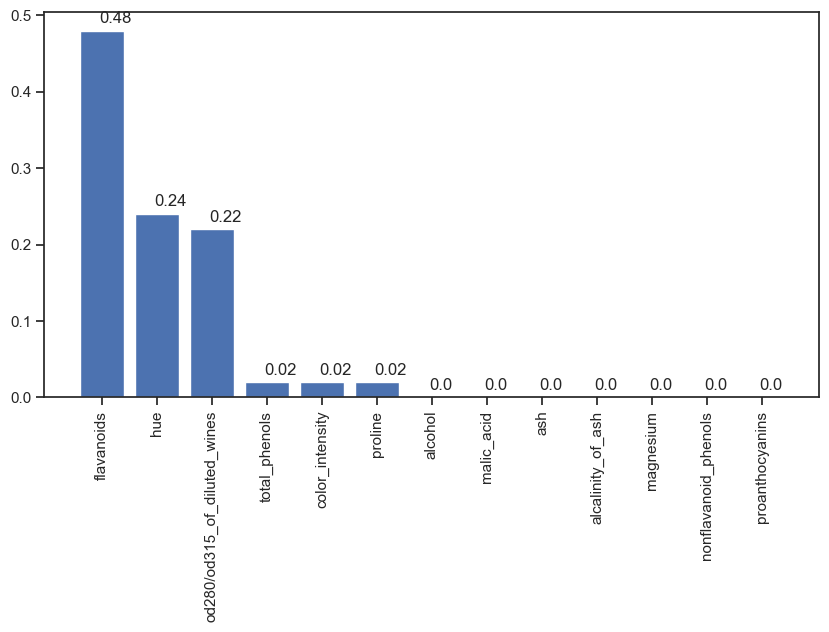

In [31]:
# Важность признаков
wine_x_ds = pd.DataFrame(data=wine['data'], columns=wine['feature_names'])
ab2 = AdaBoostClassifier(random_state=1)
ab2.fit(wine_x_ds, wine.target)
_,_ = draw_feature_importances(ab2, wine_x_ds)

In [32]:
pred_wine_y_test_ab = ab1.predict(wine_X_test)
pred_wine_y_test_ab

array([1, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 2, 0, 2,
       0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1,
       0, 1, 2, 1, 1, 0, 0, 1, 2, 0])

In [33]:
accuracy_score(wine_y_test, pred_wine_y_test_ab)

0.8703703703703703

In [34]:
print_accuracy_score_for_classes(wine_y_test, pred_wine_y_test_ab)

Метка 	 Accuracy
0 	 0.9333333333333333
1 	 0.8518518518518519
2 	 0.8333333333333334


## Алгоритм градиентного бустинга

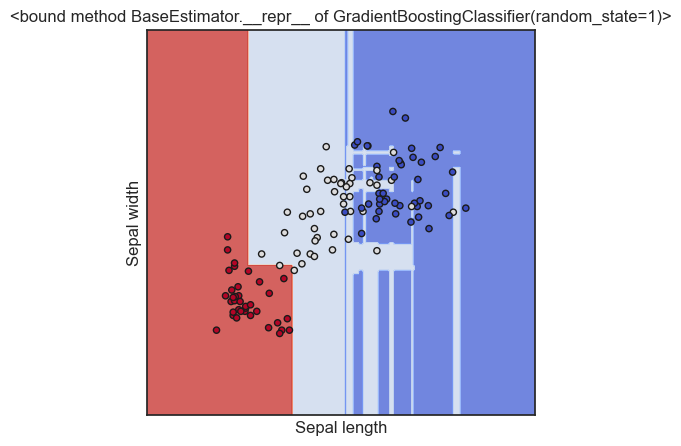

In [35]:
plot_cl(GradientBoostingClassifier(random_state=1))

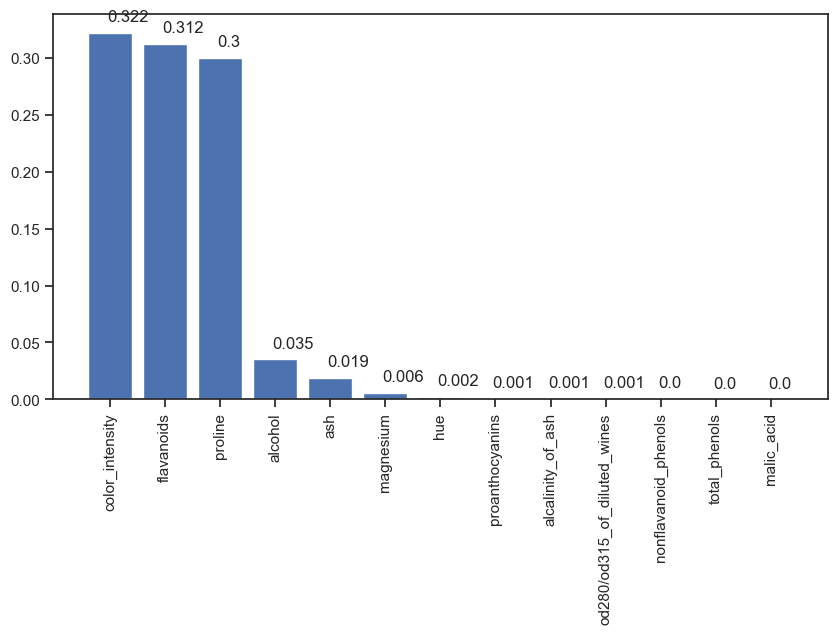

In [36]:
# Важность признаков
wine_gb_cl = GradientBoostingClassifier(random_state=1)
wine_gb_cl.fit(wine_X_train, wine_y_train)
_,_ = draw_feature_importances(wine_gb_cl, wine_x_ds)

In [37]:
pred_wine_y_test_gb = wine_gb_cl.predict(wine_X_test)
pred_wine_y_test_gb

array([1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1,
       0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 2, 0])

In [38]:
accuracy_score(wine_y_test, pred_wine_y_test_gb)

0.7962962962962963

In [39]:
print_accuracy_score_for_classes(wine_y_test, pred_wine_y_test_gb)

Метка 	 Accuracy
0 	 0.7333333333333333
1 	 0.9259259259259259
2 	 0.5833333333333334


In [43]:
pred_wine_y_train_gb2 = wine_gb_cl.predict(wine_X_train)
pred_wine_y_train_gb2

array([2, 1, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0,
       1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 2, 1, 2,
       0, 1, 0, 1, 0, 1, 1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1,
       1, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0,
       1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1,
       2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 0])

In [44]:
print_accuracy_score_for_classes(wine_y_train, pred_wine_y_train_gb2)

Метка 	 Accuracy
0 	 1.0
1 	 1.0
2 	 1.0
